In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import PIL
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

from tensorflow.keras.utils import to_categorical, Sequence

from sklearn.model_selection import train_test_split

from simple_multi_unet_model import multi_unet_model, jacard_coef  

from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
'''
#allow growth across all gpus
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
'''

#get past Pillow max image size
PIL.Image.MAX_IMAGE_PIXELS = None

2023-06-28 14:24:34.004559: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 14:24:34.220007: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 14:24:34.222111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 14:24:35.268188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `keras` framework.


In [2]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Forest,axis=-1)] = 0
    #label_seg [np.all(label==Land,axis=-1)] = 1
    #label_seg [np.all(label==Road,axis=-1)] = 2
    #label_seg [np.all(label==Vegetation,axis=-1)] = 3
    #label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 1
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


In [3]:
root_directory = '.'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            print(image_name)
            if image_name.endswith(".png"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                print(image.shape)
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = PIL.Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

            elif image_name.endswith(".npy"):   #read saved numpy arrays
               
                image = np.load(path+"/"+image_name)
                SIZE_X = (image.shape[2]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                bands = image.shape[0]
                image = image[:,:SIZE_Y,:SIZE_X]  #Crop from top left corner
                image = np.moveaxis(image, 0, 2) #move the bands to the end of the array for patchify          
                
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, bands), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

image_numpy.npy
Now patchifying image: ./images/image_numpy.npy
waikato_crop.png.old


In [4]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = PIL.Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask)
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

Now patchifying mask: ./masks/waikato_crop.shp.png


In [5]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
#print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Forest = '#FFFFFF'.lstrip('#')
Forest = np.array(tuple(int(Forest[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

#Land = '#8429F6'.lstrip('#')
#Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

#Road = '#6EC1E4'.lstrip('#') 
#Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

#Vegetation =  'FEDD3A'.lstrip('#') 
#Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

#Water = 'E2A929'.lstrip('#') 
#Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#000000'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


In [6]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [7]:
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)
print(X_train_prepr.shape)
print(X_test_prepr.shape)

(7180, 256, 256, 4)
(1796, 256, 256, 4)


In [13]:
#split up the data so we can load batches into the model, x train, y train, batch size
train_gen = DataGenerator(X_train_prepr, y_train, 32)
test_gen = DataGenerator(X_test_prepr, y_test, 32)

In [18]:
#add save checkpoints while training
checkpoint_filepath = './models/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

metrics=['accuracy', jacard_coef]

# compile keras model with defined optimozer, loss and metrics
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

ValueError: Cannot assign value to variable ' bn_data/beta:0': Shape mismatch.The variable shape (4,), and the assigned value shape (3,) are incompatible.

In [ ]:
history2=model_resnet_backbone.fit(train_gen,
          epochs=100,
          verbose=1,
          validation_data=test_gen,
          callbacks=[model_checkpoint_callback])

model_resnet_backbone.save('models/')
model_resnet_backbone.save_weights('models/model.h5')

In [26]:
### Create UNET from scratch to allow for more than 3 channels input

weights = [0.5, 0.5, 0, 0, 0, 0]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)  #
total_loss = dice_loss

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy', jacard_coef]

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 16  592         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_36 (Dropout)           (None, 256, 256, 16  0           ['conv2d_76[0][0]']              
                                )                                                           

In [27]:
#add save checkpoints while training
checkpoint_filepath = 'models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history1 = model.fit(train_gen, 
                    epochs=100, 
                    verbose=1,
                    validation_data=test_gen, 
                    callbacks=[model_checkpoint_callback])

Epoch 1/100


2023-06-28 21:35:22.809454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  3/225 [..............................] - ETA: 18:43 - loss: 0.6686 - accuracy: 0.6412 - jacard_coef: 0.3624

KeyboardInterrupt: 

In [ ]:
#plot the training and validation accuracy and loss at each epoch
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('Loss.png')
#plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig('validation.png')

In [ ]:
#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.savefig('detection.png')
plt.show()

In [36]:
#predict on external image
from smooth_tiled_predictions import predict_img_with_smooth_windowing
scaler = MinMaxScaler()

#changed to import numpy array directly

#img = cv2.imread('images/waikato_crop.png', 1)
img = np.load('images/image_numpy.npy')
#original_mask = cv2.imread("test_data/mask_part_008.png", 1)
#original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)

#weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
#dice_loss = sm.losses.DiceLoss(class_weights=weights) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
#model = tf.keras.models.load_model('./models/', custom_objects={'dice_loss_plus_2focal_loss': total_loss, 'jacard_coef':jacard_coef})
model = tf.keras.models.load_model('./models/', custom_objects={'jacard_coef':jacard_coef})

# size of patches
patch_size = 256

# Number of classes 
n_classes = 2

In [ ]:
#Predict using smooth blending

############# Error with over memory error ##################

input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)

In [37]:
#Unsmoothed patches try due to memory over error with smoothed patches


#note this now works with 4 bands for a 4 band model. Imports a numpy array directly

SIZE_X = (img.shape[2]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
bands = img.shape[0]
#large_img = PIL.Image.fromarray(img)
image = img[:,:SIZE_Y,:SIZE_X]  #Crop from top left corner
image = np.moveaxis(image, 0, 2) #move the bands to the end of the array for patchify      

patches_img = patchify(image, (patch_size, patch_size, bands), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]
                                 
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (image.shape[0], image.shape[1]))

plt.imshow(unpatched_prediction)
plt.axis('off')

(22528, 26112, 4)
(256, 256, 4)
1/1 [==============================] - 0s 44ms/step


NameError: name 'unpatchify' is not defined

(-0.5, 26111.5, 22527.5, -0.5)

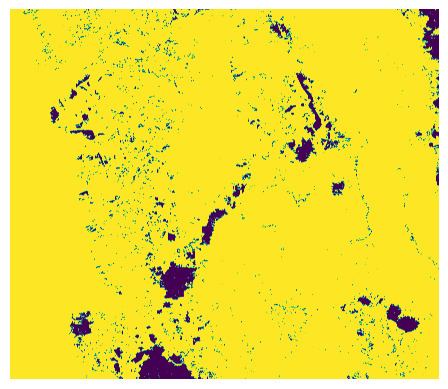

In [44]:
import patchify
unpatched_prediction = patchify.unpatchify(patched_prediction, (image.shape[0], image.shape[1]))

plt.imshow(unpatched_prediction)
plt.axis('off')

In [45]:
def label_to_rgb(predicted_image):
    
    Forest = '#3C1098'.lstrip('#')
    Forest = np.array(tuple(int(Forest[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
    
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Forest
    #segmented_img[(predicted_image == 1)] = Land
    #segmented_img[(predicted_image == 2)] = Road
    #segmented_img[(predicted_image == 3)] = Vegetation
    #segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)

prediction_with_smooth_blending=label_to_rgb(unpatched_prediction)

In [46]:
#plt.imshow(prediction_with_smooth_blending)

cv2.imwrite('forest_predicted.png', prediction_with_smooth_blending)
#output image is smaller than input because of patches. Alignment with top left corner works out to overlap nicely

True